# Finding CESM2-LE Antarctic Regional all polynya areas

* **Description**: Make "typical" polynya data files for annual, winter, and spring polynyas
    * Want decadal averages
* **Input data**: Processed polynya masks from L.Landrum
* **Output data**: Netcdf file with typical polynya masks and polynyas
* **Creator**: Alice DuVivier
* **Date**: October 2024

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pop_tools
from datetime import timedelta
from datetime import datetime
import glob
import dask
from matplotlib.gridspec import GridSpec
import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import nc_time_axis

import utils

## Get grid data

In [2]:
# load ocean grid
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [3]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


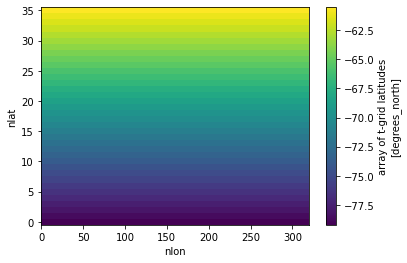

In [4]:
ds_grid.TLAT.plot()

## Load polynya data
- Get both concentration (aice) and thickness (hi) based metrics

In [5]:
# list all 50 cmip6 standard forcing CESM2-LE ensemble numbers
ens_mems = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
            '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
            '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
            '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
            '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']

### Get ice concentration (aice=85%) threshold data

In [6]:
# set input directory
dir_in = '/glade/work/landrum/projects/Antarctic_polynyas/CESM2-LE/ice/polynyas/monthly/aice/'
print('getting ice concentration data')

getting ice concentration data


In [7]:
%%time
print('loading historical data')
ds_hist = xr.Dataset()

# set input names
fin = 'b.e21.BHISTcmip6.f09_g17.LE2-'

for m in ens_mems[0:3]:
    file_in = dir_in+fin+m+'.aice_85%thresh.polynya_sh.185001-201412.nc'
    #print(file_in)
    ds_tmp=xr.open_mfdataset(file_in,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)
    # assign coordinates to the dataset
    ds_tmp['lat']= ds_tmp.tlat1d
    ds_tmp['lon']= ds_tmp.tlon1d
    # keep only some variables
    keep_vars=['time','lat','lon','tlat1d','tlon1d','polynyas']
    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    # now concatenate over member_id
    ds_hist = xr.concat([ds_hist,ds_tmp], dim='member_id')


loading historical data
CPU times: user 181 ms, sys: 47.5 ms, total: 228 ms
Wall time: 4.86 s


In [8]:
%%time
print('loading future data')
ds_futr = xr.Dataset()

# set input names
fin = 'b.e21.BSSP370cmip6.f09_g17.LE2-'

for m in ens_mems[0:3]:
    file_in = dir_in+fin+m+'.aice_85%thresh.polynya_sh.201501-210012.nc'
    #print(file_in)
    ds_tmp=xr.open_mfdataset(file_in,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)
    # assign coordinates to the dataset
    ds_tmp['lat']= ds_tmp.tlat1d
    ds_tmp['lon']= ds_tmp.tlon1d
    # keep only some variables
    keep_vars=['time','lat','lon','tlat1d','tlon1d','polynyas']
    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    # now concatenate over member_id
    ds_futr = xr.concat([ds_futr,ds_tmp], dim='member_id')


loading future data
CPU times: user 77 ms, sys: 14.5 ms, total: 91.5 ms
Wall time: 1.08 s


In [9]:
ds_1 = xr.concat((ds_hist, ds_futr),dim='time')

### Get ice thickness (hi=0.4m) threshold data

In [10]:
# set input directory
dir_in = '/glade/work/landrum/projects/Antarctic_polynyas/CESM2-LE/ice/polynyas/monthly/hi/'
print('getting ice thickness data')

getting ice thickness data


In [11]:
%%time
print('loading historical data')
ds_hist = xr.Dataset()

# set input names
fin = 'b.e21.BHISTcmip6.f09_g17.LE2-'

for m in ens_mems:
    print(m)
    file_in = dir_in+fin+m+'.hi_0.4mthresh.polynya_sh.185001-201412.nc'
    #print(file_in)
    ds_tmp=xr.open_mfdataset(file_in,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)
    # assign coordinates to the dataset
    ds_tmp['lat']= ds_tmp.tlat1d
    ds_tmp['lon']= ds_tmp.tlon1d
    # keep only some variables
    keep_vars=['time','lat','lon','tlat1d','tlon1d','polynyas']
    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    # now concatenate over member_id
    ds_hist = xr.concat([ds_hist,ds_tmp], dim='member_id')


loading historical data
1001.001
1021.002
1041.003
1061.004
1081.005
1101.006
1121.007
1141.008
1161.009
1181.010
1231.001
1231.002
1231.003
1231.004
1231.005
1231.006
1231.007
1231.008
1231.009
1231.010
1251.001
1251.002
1251.003
1251.004
1251.005
1251.006
1251.007
1251.008
1251.009
1251.010
1281.001
1281.002
1281.003
1281.004
1281.005
1281.006
1281.007
1281.008
1281.009
1281.010
1301.001
1301.002
1301.003
1301.004
1301.005
1301.006
1301.007
1301.008
1301.009
1301.010
CPU times: user 1.55 s, sys: 626 ms, total: 2.18 s
Wall time: 49.3 s


In [12]:
%%time
print('loading future data')
ds_futr = xr.Dataset()

# set input names
fin = 'b.e21.BSSP370cmip6.f09_g17.LE2-'

for m in ens_mems:
    print(m)
    file_in = dir_in+fin+m+'.hi_0.4mthresh.polynya_sh.201501-210012.nc'
    #print(file_in)
    ds_tmp=xr.open_mfdataset(file_in,combine='by_coords',chunks={}, parallel=True, compat='override', coords='minimal',decode_times=True)
    # assign coordinates to the dataset
    ds_tmp['lat']= ds_tmp.tlat1d
    ds_tmp['lon']= ds_tmp.tlon1d
    # keep only some variables
    keep_vars=['time','lat','lon','tlat1d','tlon1d','polynyas']
    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    # now concatenate over member_id
    ds_futr = xr.concat([ds_futr,ds_tmp], dim='member_id')


loading future data
1001.001
1021.002
1041.003
1061.004
1081.005
1101.006
1121.007
1141.008
1161.009
1181.010
1231.001
1231.002
1231.003
1231.004
1231.005
1231.006
1231.007
1231.008
1231.009
1231.010
1251.001
1251.002
1251.003
1251.004
1251.005
1251.006
1251.007
1251.008
1251.009
1251.010
1281.001
1281.002
1281.003
1281.004
1281.005
1281.006
1281.007
1281.008
1281.009
1281.010
1301.001
1301.002
1301.003
1301.004
1301.005
1301.006
1301.007
1301.008
1301.009
1301.010
CPU times: user 1.32 s, sys: 436 ms, total: 1.76 s
Wall time: 30.8 s


In [13]:
ds_2 = xr.concat((ds_hist, ds_futr),dim='time')

### Clean data now

In [14]:
# rename dimensions to be nlat and nlon
ds_1 = ds_1.rename({'lat':'nlat'})
ds_1 = ds_1.rename({'lon':'nlon'})
ds_2 = ds_2.rename({'lat':'nlat'})
ds_2 = ds_2.rename({'lon':'nlon'})

In [15]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_1 = ds_1.where(((ds_1['tlat1d'] <= lat_max) & (ds_1['tlat1d'] >= lat_min)), drop=True)
ds_2 = ds_2.where(((ds_2['tlat1d'] <= lat_max) & (ds_2['tlat1d'] >= lat_min)), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
 

In [16]:
ds_1

<xarray.Dataset>
Dimensions:   (time: 3012, member_id: 3, nlon: 320, nlat: 36)
Coordinates:
  * time      (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
  * nlat      (nlat) float32 -79.22 -78.69 -78.15 ... -61.59 -61.06 -60.52
  * nlon      (nlon) float32 -39.44 -38.31 -37.19 -36.06 ... 317.2 318.3 319.4
Dimensions without coordinates: member_id
Data variables:
    tlon1d    (time, member_id, nlon, nlat) float32 dask.array<chunksize=(1980, 1, 320, 36), meta=np.ndarray>
    polynyas  (member_id, time, nlat, nlon) float64 dask.array<chunksize=(1, 1980, 36, 320), meta=np.ndarray>
    tlat1d    (time, member_id, nlat) float32 dask.array<chunksize=(1980, 1, 36), meta=np.ndarray>

In [17]:
# keep just the variable of interest and only first polyID 
polynyas_aice = ds_1['polynyas']
polynyas_hi = ds_2['polynyas']

In [18]:
polynyas_aice

<xarray.DataArray 'polynyas' (member_id: 3, time: 3012, nlat: 36, nlon: 320)>
dask.array<where, shape=(3, 3012, 36, 320), dtype=float64, chunksize=(1, 1980, 36, 320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
  * nlat     (nlat) float32 -79.22 -78.69 -78.15 -77.62 ... -61.59 -61.06 -60.52
  * nlon     (nlon) float32 -39.44 -38.31 -37.19 -36.06 ... 317.2 318.3 319.4
Dimensions without coordinates: member_id
Attributes:
    long_name:  Polynya grid cells with < 85% aice and bounded by aice > 85% ...

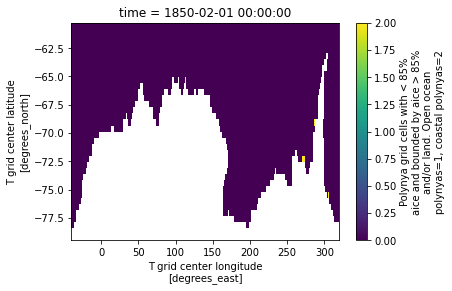

In [19]:
polynyas_aice.isel(member_id=0,time=0).plot()

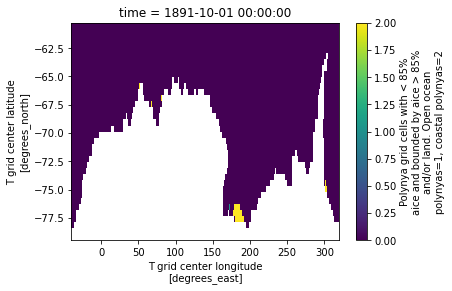

In [20]:
polynyas_aice.isel(member_id=0,time=500).plot()

In [21]:
# Set all polynyas to be in mask since there are so few open water polynyas
# In the file, 0 = not polynya, 1 = open water polynya, 2 = coastal polynya
# We want to look at all polynyas for now, so set coastal to one also
polynyas_aice = polynyas_aice.where(polynyas_aice != 2,1)
polynyas_hi = polynyas_hi.where(polynyas_hi != 2,1)

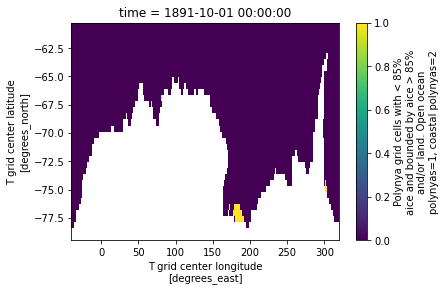

In [22]:
# check
polynyas_aice.isel(member_id=0,time=500).plot()

### Fix time array to be useable

In [23]:
# looks like there are 3012 times, which is 251 yrs * 12 months
# starts 185001-210012
polynyas_aice.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 4, 1, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(2100, 11, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2101, 1, 1, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-02-01 00:00:00 ... 2101-01-01 00:00:00
Attributes:
    bounds:     time_bounds
    long_name:  model time

In [24]:
# make array of the dates
dates = pd.date_range(start="1850-01-15", end="2101-01-15", freq="M")

In [25]:
# check length
print(len(dates))
dates

3012


DatetimeIndex(['1850-01-31', '1850-02-28', '1850-03-31', '1850-04-30',
               '1850-05-31', '1850-06-30', '1850-07-31', '1850-08-31',
               '1850-09-30', '1850-10-31',
               ...
               '2100-03-31', '2100-04-30', '2100-05-31', '2100-06-30',
               '2100-07-31', '2100-08-31', '2100-09-30', '2100-10-31',
               '2100-11-30', '2100-12-31'],
              dtype='datetime64[ns]', length=3012, freq='M')

In [26]:
# reassign the polynya time array
polynyas_aice['time'] = dates
polynyas_hi['time'] = dates

## Calculate typical polynya areas
- Areas that are counted as polynya > 10% of the time (in that season)
- Look at whole year and winter (JAS) and spring (OND) seasons

In [27]:
polynyas_winter_aice = polynyas_aice.where((polynyas_aice.time.dt.month >= 7) & (polynyas_aice.time.dt.month <= 9), drop=True)
polynyas_winter_hi = polynyas_hi.where((polynyas_hi.time.dt.month >= 7) & (polynyas_hi.time.dt.month <= 9), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [28]:
polynyas_spring_aice = polynyas_aice.where((polynyas_aice.time.dt.month >= 10) & (polynyas_aice.time.dt.month <= 12), drop=True)
polynyas_spring_hi = polynyas_hi.where((polynyas_hi.time.dt.month >= 10) & (polynyas_hi.time.dt.month <= 12), drop=True)

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Calculate for each decade

In [29]:
# specify some arrays that will become coordinate arrays
decades = list(range(1960,2100,10))
decade_names = ['1960','1970','1980','1990','2000','2010','2020','2030','2040','2050','2060','2070','2080','2090']

In [30]:
# get dimensions of the grid we need to iterate over
xlen = len(ds_1.nlon)
ylen = len(ds_1.nlat)
dlen = len(decades)
print(xlen,ylen,dlen)

320 36 14


In [41]:
# Loop through decades - do aice threshold

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,ylen,xlen])
array_decadal_winter = np.zeros([dlen,ylen,xlen])
array_decadal_spring = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    data_sub = polynyas_aice.where((polynyas_aice.time.dt.year >= yy_st)&(polynyas_aice.time.dt.year <= yy_ed),drop=True)
    data_winter_sub = polynyas_winter_aice.where((polynyas_winter_aice.time.dt.year >= yy_st)&(polynyas_winter_aice.time.dt.year <= yy_ed),drop=True)
    data_spring_sub = polynyas_winter_aice.where((polynyas_spring_aice.time.dt.year >= yy_st)&(polynyas_spring_aice.time.dt.year <= yy_ed),drop=True)
    # calculate all times
    total_time = len(data_sub.time)
    winter_time = len(data_winter_sub.time)
    spring_time = len(data_spring_sub.time)
    # get percentages
    tmp_all = data_sub.sum(dim='time')/total_time
    tmp_winter = data_winter_sub.sum(dim='time')/winter_time
    tmp_spring = data_spring_sub.sum(dim='time')/spring_time
    # get ensemble mean
    array_decadal_all[count,:,:] = tmp_all.mean(dim='member_id')
    array_decadal_winter[count,:,:] = tmp_winter.mean(dim='member_id')
    array_decadal_spring[count,:,:] = tmp_spring.mean(dim='member_id')

# convert to xarray
pct_all_aice = xr.DataArray(array_decadal_all,dims=('decades','nlat','nlon'))
pct_all_aice['decades'] = decades
pct_all_aice['nlat'] = ds_1.nlat
pct_all_aice['nlon'] = ds_1.nlon

pct_winter_aice = xr.DataArray(array_decadal_winter,dims=('decades','nlat','nlon'))
pct_winter_aice['decades'] = decades
pct_winter_aice['nlat'] = ds_1.nlat
pct_winter_aice['nlon'] = ds_1.nlon

pct_spring_aice = xr.DataArray(array_decadal_spring,dims=('decades','nlat','nlon'))
pct_spring_aice['decades'] = decades
pct_spring_aice['nlat'] = ds_1.nlat
pct_spring_aice['nlon'] = ds_1.nlon

Calculating decadal means for 1960s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1970s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1980s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1990s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2000s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2010s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2020s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2030s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2040s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2050s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2060s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2070s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2080s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2090s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [42]:
# Loop through decades - do hi threshold

# make numpy array to fill and specify dimensions
array_decadal_all = np.zeros([dlen,ylen,xlen])
array_decadal_winter = np.zeros([dlen,ylen,xlen])
array_decadal_spring = np.zeros([dlen,ylen,xlen])

for dec in decades:
    print('Calculating decadal means for '+str(dec)+'s')
    # need to specify which spot in the array we'll fill for the decade
    if dec == 1960:
        count = 0
    else: 
        count = count+1    
    # set the start and end years for this decade
    yy_st = dec - 2
    yy_ed = dec +3
    yy = list(range(yy_st,yy_ed,1)) 
    # get data subset
    data_sub = polynyas_hi.where((polynyas_hi.time.dt.year >= yy_st)&(polynyas_hi.time.dt.year <= yy_ed),drop=True)
    data_winter_sub = polynyas_winter_hi.where((polynyas_winter_hi.time.dt.year >= yy_st)&(polynyas_winter_hi.time.dt.year <= yy_ed),drop=True)
    data_spring_sub = polynyas_winter_hi.where((polynyas_spring_hi.time.dt.year >= yy_st)&(polynyas_spring_hi.time.dt.year <= yy_ed),drop=True)
    # calculate all times
    total_time = len(data_sub.time)
    winter_time = len(data_winter_sub.time)
    spring_time = len(data_spring_sub.time)
    # get percentages
    tmp_all = data_sub.sum(dim='time')/total_time
    tmp_winter = data_winter_sub.sum(dim='time')/winter_time
    tmp_spring = data_spring_sub.sum(dim='time')/spring_time
    # get ensemble mean
    array_decadal_all[count,:,:] = tmp_all.mean(dim='member_id')
    array_decadal_winter[count,:,:] = tmp_winter.mean(dim='member_id')
    array_decadal_spring[count,:,:] = tmp_spring.mean(dim='member_id')

# convert to xarray
pct_all_hi = xr.DataArray(array_decadal_all,dims=('decades','nlat','nlon'))
pct_all_hi['decades'] = decades
pct_all_hi['nlat'] = ds_1.nlat
pct_all_hi['nlon'] = ds_1.nlon

pct_winter_hi = xr.DataArray(array_decadal_winter,dims=('decades','nlat','nlon'))
pct_winter_hi['decades'] = decades
pct_winter_hi['nlat'] = ds_1.nlat
pct_winter_hi['nlon'] = ds_1.nlon

pct_spring_hi = xr.DataArray(array_decadal_spring,dims=('decades','nlat','nlon'))
pct_spring_hi['decades'] = decades
pct_spring_hi['nlat'] = ds_1.nlat
pct_spring_hi['nlon'] = ds_1.nlon

Calculating decadal means for 1960s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1970s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1980s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 1990s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2000s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2010s
Calculating decadal means for 2020s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2030s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2040s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2050s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2060s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2070s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Calculating decadal means for 2090s


/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [43]:
# make arrays of "typical" polynyas

# make array to fill
polynya_typical_all_aice = pct_all_aice.where(pct_all_aice == 1, other = 1)
polynya_typical_winter_aice = pct_winter_aice.where(pct_winter_aice == 1, other = 1)
polynya_typical_spring_aice = pct_spring_aice.where(pct_spring_aice == 1, other = 1)

# keep values where polynyas > 10% (0.1) of the time
polynya_typical_all_aice = polynya_typical_all_aice.where(pct_all_aice >= 0.1)
polynya_typical_winter_aice = polynya_typical_winter_aice.where(pct_winter_aice >= 0.1)
polynya_typical_spring_aice = polynya_typical_spring_aice.where(pct_spring_aice >= 0.1)

# make array to fill
polynya_typical_all_hi = pct_all_hi.where(pct_all_hi == 1, other = 1)
polynya_typical_winter_hi = pct_winter_hi.where(pct_winter_hi == 1, other = 1)
polynya_typical_spring_hi = pct_spring_hi.where(pct_spring_hi == 1, other = 1)

# keep values where polynyas > 10% (0.1) of the time
polynya_typical_all_hi = polynya_typical_all_hi.where(pct_all_hi >= 0.1)
polynya_typical_winter_hi = polynya_typical_winter_hi.where(pct_winter_hi >= 0.1)
polynya_typical_spring_hi = polynya_typical_spring_hi.where(pct_spring_hi >= 0.1)

In [44]:
# assign some coordinates for later
polynya_typical_all_hi['TLAT'] = ds_grid.TLAT
polynya_typical_all_hi['TLONG'] = ds_grid.TLONG
polynya_typical_all_hi['TAREA'] = ds_grid.TAREA

## Put together into one dataset

- Netcdf with variable dimension: (nlat x nlon)

In [45]:
ds_out = xr.Dataset()

ds_out['polynya_typical_all_aice'] = polynya_typical_all_aice
ds_out['polynya_typical_winter_aice'] = polynya_typical_winter_aice
ds_out['polynya_typical_spring_aice'] = polynya_typical_spring_aice

ds_out['polynya_typical_all_hi'] = polynya_typical_all_hi
ds_out['polynya_typical_winter_hi'] = polynya_typical_winter_hi
ds_out['polynya_typical_spring_hi'] = polynya_typical_spring_hi

ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Typical polynyas from SSMI CDR data for whole year, winter (JAS), and spring (OND). For whole record (1958-2021) and "present day" period (2000-2020). Uses both ice concentration (aice=85%) and ice thickness (hi=0.4m) thresholds.'

ds_out

<xarray.Dataset>
Dimensions:                      (decades: 14, nlat: 36, nlon: 320)
Coordinates:
  * decades                      (decades) int64 1960 1970 1980 ... 2080 2090
  * nlat                         (nlat) float32 -79.22 -78.69 ... -61.06 -60.52
  * nlon                         (nlon) float32 -39.44 -38.31 ... 318.3 319.4
    ULONG                        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    ULAT                         (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLONG                        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT                         (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TAREA                        (nlat, nlon) float64 dask.array<chunksize=(36, 320), meta=np.ndarray>
Data variables:
    polynya_typical_all_aice     (decades, nlat, nlon) float64 nan nan ... nan
    polynya_typical_winter_aice  (decades, nlat, nlon) float64 nan nan ... nan
    polynya_typical_spring_aice  (decades, nlat, nlon) float64 nan nan ... nan
    polynya_typical_all_hi       (decades, nlat, nlon) float64 nan nan ... nan
    polynya_typical_winter_hi    (decades, nlat, nlon) float64 nan nan ... nan
    polynya_typical_spring_hi    (decades, nlat, nlon) float64 nan nan ... nan
Attributes:
    author:          Alice DuVivier
    date_processed:  2024-10-16
    contents:        Typical polynyas from SSMI CDR data for whole year, wint...

In [46]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	decades: (14,)
	nlat: (36,)
	nlon: (320,)
Coordinates:
	decades:
		[1960 1970 1980 1990 2000 2010 2020 2030 2040 2050 2060 2070 2080 2090]
	nlat:
		[-79.22052  -78.68631  -78.15209  -77.617874 -77.08366  -76.54944
 -76.01522  -75.481    -74.946785 -74.41257  -73.87835  -73.34413
 -72.80991  -72.275696 -71.74148  -71.20726  -70.673035 -70.13882
 -69.6046   -69.07037  -68.536156 -68.00193  -67.46771  -66.93349
 -66.39927  -65.86504  -65.330826 -64.7966   -64.262375 -63.72815
 -63.193928 -62.659702 -62.125477 -61.59125  -61.057022 -60.522797]
	nlon:
		[-3.943750e+01 -3.831250e+01 -3.718750e+01 -3.606250e+01 -3.493750e+01
 -3.381250e+01 -3.268750e+01 -3.156250e+01 -3.043750e+01 -2.931250e+01
 -2.818750e+01 -2.706250e+01 -2.593750e+01 -2.481250e+01 -2.368750e+01
 -2.256250e+01 -2.143750e+01 -2.031250e+01 -1.918750e+01 -1.806250e+01
 -1.693750e+01 -1.581250e+01 -1.468750e+01 -1.356250e+01 -1.243750e+01
 -1.131250e+01 -1.018750e+01 -9.062500e+00 -7.937500e+00 -6.812500e+00
 -5.68

## Export and Save

In [47]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.01 GB.


In [48]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'
file_out = 'CESM_grid_CESM2-LE_typical_polynya.nc'
fout = path_out + file_out

In [49]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)